# Traffic Simulation

First I have included the original code from class (Session 9) that I will build on and adapt for the pirposes of the assignment.

In [81]:
# Use this cell to import libraries if needed. 
import sys
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user matplotlib
!{sys.executable} -m pip install --user tqdm
!{sys.executable} -m pip install --user ffmpeg
!{sys.executable} -m pip install --user scipy


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 35.2 MB 10.4 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [82]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt # pyplot doesn't get imported by default
import ffmpeg
import copy
import scipy.stats as sts

# Code from class

In [3]:
# Code taken and adapted from Session 9
# Find the original code here: https://nbviewer.org/urls/course-resources.minerva.kgi.edu/uploaded_files/mke/00212840-6806/traffic-simulation-examples.ipynb
class TrafficSimulation:

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.step_counter = 0

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1


    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

        # Update step counter
        self.step_counter += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

    # Initialize plot for visualizations
    def initialize(self):
        """ This method initializes the plot"""
        self.figure, self.axes = plt.subplots()

    def observe(self):
        """A method used to plot the state of the configuration on the plot at each step"""
        
        import matplotlib.colors as colors

        # Create a custom color map
        blues = plt.cm.Blues(np.linspace(0, 0.9, self.max_speed+1))
        # Make the first color white (for stopped cars)
        blues[0] = [0,0,0,1]
        # Define the colors for the background
        gray = [0.5, 0.5, 0.5, 1]
        # Combine the colors for the cars and background into a single colormap
        cmap_colors = np.vstack((gray, blues))
        custom_cmap = colors.ListedColormap(cmap_colors)


        plot = self.axes.imshow(self.state.reshape(1, -1), vmin=-1, vmax=self.max_speed+1, cmap = custom_cmap)
        self.axes.set_title(f'State at step {self.step_counter}')


        
        return plot

## Visualize animation (my code)

In [8]:

# Adapted from session on Percolation: https://sle-collaboration.minervaproject.com/?id=bf8bd296-4a07-438c-8ec1-d288cbaf1a7c&userId=10834&name=Vicki+Petrova&avatar=https%3A//s3.amazonaws.com/picasso.fixtures/Victoria_Petrova_10834_2020-09-11T21%3A29%3A05.741Z&iframed=1&readOnly=0&isInstructor=0&enableSavingIndicators=1&signature=18892ca2e9f2234a870cf15e64e1e66c1806d84aa09fbbaf1762c56c37e83225
def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    """
    This function creates a visualization for the behavior of the forest fire model. 
    """
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    from IPython import display
    from tqdm import tqdm
    
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return [sim.observe()]

    sim.initialize()
    progress_bar = tqdm(total=total_frames)
    # You may need to brew install ffmpeg and change the path as neccessary. 
    plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
    
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    
    sim.figure.clf()
    return output

In [5]:

sim = TrafficSimulation(
    road_length=50, car_density=0.4, max_speed=5, prob_slow=0.1)
make_animation(sim, total_frames=50, steps_per_frame=1)

100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


<Figure size 432x288 with 0 Axes>

# Examples 
from https://nbviewer.org/urls/course-resources.minerva.kgi.edu/uploaded_files/mke/00212840-6806/traffic-simulation-examples.ipynb

## Example: optimized

In [6]:
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
initial_state = sim.state.copy()
np.random.seed(123)  # Set the seed so we can compare to random simulations
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
sim.state = initial_state.copy()
for i in range(10):
    sim.display()
    sim.update(optimized=True)


4....0.4...0....4......1..2.5131...3..3........5.2
...3..1...3.1.......4....2.1000..2..1....3.....0.0
.....2..2..1..2.........4.1000.1...2.1.......4.0.0
.......2.1...2...3.......10000...2..1.1......0..10
1.......1..2...2.....4...0000.1...1.0..1.....0..0.
..2......1....3...3.....30000..1..0.0....2....1.0.
....2.....1......3....4.0000.1...20.0......2..0..1
.2....2.....2........4.10000...2.0.10.......1..1..
....3...2......3......100000....10.0.1........2..2
..3...2...2.......3...000000....0.10..1.........2.


In [7]:
sim = TrafficSimulation(
    road_length=50, car_density=0.3, max_speed=5, prob_slow=0.5)
sim.state = initial_state.copy()
make_animation(sim, total_frames=20, steps_per_frame=1)

100%|██████████| 20/20 [00:01<00:00, 14.27it/s]


<Figure size 432x288 with 0 Axes>

## Example: Simple acceleration

In [8]:
sim = TrafficSimulation(
    road_length=20, car_density=1/20, max_speed=5, prob_slow=0)
sim.state[sim.state > 0] = 0  # Force the speed of the car to be 0

initial_state = sim.state.copy()

for i in range(10):
    sim.display()
    sim.update()

......0.............
.......1............
.........2..........
............3.......
................4...
.5..................
......5.............
...........5........
................5...
.5..................


In [9]:
sim = TrafficSimulation(
    road_length=20, car_density=1/20, max_speed=5, prob_slow=0)
sim.state = initial_state 
make_animation(sim, total_frames=10, steps_per_frame=1)

100%|██████████| 10/10 [00:00<00:00, 13.07it/s]


<Figure size 432x288 with 0 Axes>

## Example: Braking

In [10]:
sim = TrafficSimulation(
    road_length=20, car_density=2/20, max_speed=5, prob_slow=0)
sim.state[:7] = [-1, -1, 2, -1, -1, -1, 1]

initial_state = sim.state.copy()
for i in range(10):
    sim.display()
    sim.update()

..2...1........1....
.....3..2........2..
3......2...3........
....4.....3....4....
5........5....4.....
.....5.......4.....5
....5.....5.......5.
...5.....5.....5....
5.......5.....5.....
.....5.......5.....5


In [11]:
sim = TrafficSimulation(
    road_length=20, car_density=2/20, max_speed=5, prob_slow=0)
sim.state = initial_state
make_animation(sim, total_frames=10, steps_per_frame=1)

100%|██████████| 10/10 [00:00<00:00, 12.57it/s]


<Figure size 432x288 with 0 Axes>

## Example: Random slow down

In [12]:
np.random.seed(123)
sim = TrafficSimulation(
    road_length=50, car_density=2/50, max_speed=5, prob_slow=0.5)

initial_state = sim.state.copy()

for i in range(10):
    sim.display()
    sim.update()

..........5..2....................................
...........1...2..................................
.............2....3...............................
................3.....4...........................
...................3......4.......................
......................3........5..................
.........................3.........4..............
.............................4..........5.........
..................................5.........4.....
.......................................5.........5


In [13]:
sim = TrafficSimulation(
    road_length=50, car_density=2/50, max_speed=5, prob_slow=0.5)
sim.state = initial_state
make_animation(sim, total_frames=10, steps_per_frame=1)

100%|██████████| 10/10 [00:00<00:00, 16.87it/s]


<Figure size 432x288 with 0 Axes>

## Example: Free-flowing traffic

In [14]:
sim = TrafficSimulation(
    road_length=50, car_density=0.1, max_speed=5, prob_slow=0.1)

initial_state = sim.state.copy()

for i in range(20):
    sim.display()
    sim.update()

1...4.......0.....................0..........5....
.1......4....1.....................1.............4
1..2........4..2.....................2............
..2...3.......2...3.....................3.........
.....3....4.....2.....4.....................4.....
.........4.....5...3.......5....................4.
...5..........5...3....4........5.................
........5........3...3......5........5............
............4.......3....4.......5........5.......
.................5......4.....5.......5........5..
..5...................5......5.....5.......5......
.......5...................5......5.....5.......5.
...5........5...................5.....4.....4.....
........5........5...................5.....5.....5
....5........5........5...................5.....5.
...5.....5.......4.........5...................5..
..5.....5.....5.......5.........5.................
.......5.....5.....5.......5.........5............
............5.....5.....5.......5........4........
.................5.....5.....5.

In [15]:
sim = TrafficSimulation(
    road_length=50, car_density=0.1, max_speed=5, prob_slow=0.1)

sim.state = initial_state
make_animation(sim, total_frames=10, steps_per_frame=1)

100%|██████████| 10/10 [00:00<00:00, 10.51it/s]


<Figure size 432x288 with 0 Axes>

## Example: Traffic jams 1

In [16]:
np.random.seed(123)
sim = TrafficSimulation(
    road_length=50, car_density=0.15, max_speed=5, prob_slow=0.2)

initial_state = sim.state.copy()

for i in range(20):
    sim.display()
    sim.update()

5.........5.42....3...........4.........4.....3...
.....5.....10..2......4............5.........5...3
...4......50.1....3........5...........4........3.
..4.....5.0.1..2......4.........5...........5.....
.......5.1.1..2...3.......4..........5...........5
....5..0..1.1....3....4........5.........4........
......20..0...2......4.....5........5.........5...
.5....0.1..1.....3.......4......5........5........
.....4.1..2..2.......4.......4.......5........5...
.5....1..2..2..2.........4........5.......5.......
.....4..2..2..2...3..........4.........5.......5..
..5....2..2..2..2.....4...........5.........5.....
......4..2..2..2...3.......5...........5.........5
....5..1...2..2...3...3.........5...........5.....
......2.1....2...3...3....4..........5...........5
....5.0...2.....3..2.....4.....5..........5.......
....0..1.....3....2...3.......5.....5..........5..
..5.0....2.......4...3....4........5.....5........
..0..1......3.......3...3.....4........4......5...
4..1...2.......3.......3....4..

In [17]:
sim = TrafficSimulation(
    road_length=50, car_density=0.15, max_speed=5, prob_slow=0.2)

sim.state = initial_state
make_animation(sim, total_frames=10, steps_per_frame=1)

100%|██████████| 10/10 [00:00<00:00, 12.90it/s]


<Figure size 432x288 with 0 Axes>

## Example: Traffic jams 2

In [18]:
sim = TrafficSimulation(
    road_length=50, car_density=0.15, max_speed=5, prob_slow=0)

initial_state = sim.state.copy()

for i in range(20):
    sim.display()
    sim.update()

.....3......3.2.................04....2....1.5....
5........4...1...3..............0....4...3..1.....
.....5......3..2.....4...........1......3..2..2...
..........5...2...3.......5........2......2..2...3
...4.........3...3....4........5......3.....2...3.
..4.....5.......3....4.....5........5.....4....3..
.4.....5.....5......4.....5.....5........5....4...
4.....5.....5.....5......5.....5.....5.......4....
.....5.....5.....5.....5......5.....5.....5......4
....5.....5.....5.....5.....5......5.....5.....5..
..5......5.....5.....5.....5.....5......5.....5...
.5.....5......5.....5.....5.....5.....5......5....
5.....5.....5......5.....5.....5.....5.....5......
.....5.....5.....5......5.....5.....5.....5.....5.
...5......5.....5.....5......5.....5.....5.....5..
..5.....5......5.....5.....5......5.....5.....5...
.5.....5.....5......5.....5.....5......5.....5....
5.....5.....5.....5......5.....5.....5......5.....
.....5.....5.....5.....5......5.....5.....5......5
....5.....5.....5.....5.....5..

In [19]:
sim = TrafficSimulation(
    road_length=50, car_density=0.15, max_speed=5, prob_slow=0)

sim.state = initial_state
make_animation(sim, total_frames=10, steps_per_frame=1)

100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


<Figure size 432x288 with 0 Axes>

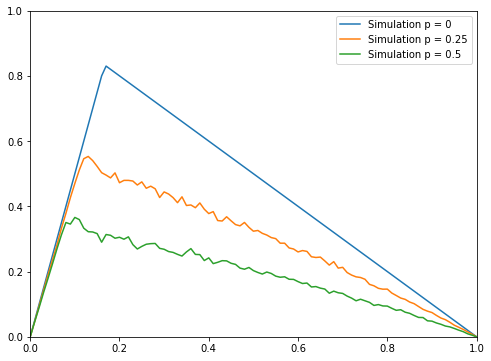

In [20]:
import numpy as np
import matplotlib.pyplot as plt

class TrafficSimulation:

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # The number of empty cells between this car and the next plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (self.state[i] > 0) and (np.random.uniform() < self.prob_slow):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = -np.ones(self.road_length, dtype=int)
        for i in range(self.road_length):
            if self.state[i] != -1:
                new_state[(i + self.state[i]) % self.road_length] = self.state[i]
        self.state = new_state

        # Update traffic flow history
        self.average_traffic_flow.append(sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1

    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))


max_speed = 5
p_slows = [0, 0.25, 0.5]
car_densities = np.linspace(0, 1, 101)

trials = 50 # Number of times to repeat the simulation at each density
sim_flow_results = {}  # The results go here

for p_slow in p_slows:
    sim_flow_results[p_slow] = []
    for density in car_densities:
        flows = []
        for trial in range(trials):
            sim = TrafficSimulation(
                road_length=100,
                car_density=density,
                max_speed=max_speed,
                prob_slow=p_slow)
            # Run for 50 steps to reach an equilibrium state
            for step in range(50):
                sim.update()
            # Record the final average traffic flow
            flows.append(sim.average_traffic_flow[-1])
        sim_flow_results[p_slow].append(np.mean(flows))

plt.figure(figsize=(8, 6))
for p, flow in sim_flow_results.items():
    plt.plot(car_densities, flow, label=f'Simulation p = {p}')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [21]:
def mfa(v, density, p_slow):
    '''
    Calculate the updated distribution over speeds given the current
    distribution by applying the MFA traffic rules.

    Inputs:
    
        v (list of float) The car speed probability vector. v[i] is the
        probability that a car is moving at speed i.

        density (float) The average number of cars per cell on the road.
        
        p_slow (float) The probability of random slow-down.
    
    Returns: A new, updated car speed probability vector.
    '''
    v_max = len(v) - 1
    new_v = [0] * len(v)  # The updated speed probability vector
    
    # Probability of a car appearing in front of you
    car_probabilities = [density] * (v_max + 1)
    car_probabilities = [None] + [
        (1-density)**(distance-1) * density for distance in range(1, v_max + 1)]
    car_probabilities.append(1 - np.sum(car_probabilities[1:]))
    
    for v_from in range(v_max + 1):
        
        # Current speed, will be updated below
        speed = v_from
        
        # Accelerate
        if speed < v_max:
            speed += 1
        
        # Brake when there is a car in front at each distance from 1 to speed
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = car_probabilities[distance]
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance
        
        # No cars in front up to distance == speed
        no_cars = 1 - np.sum(car_probabilities[1:speed+1])
        new_v[speed] += v[v_from] * no_cars * (1-p_slow)
        new_v[speed-1] += v[v_from] * no_cars * p_slow
        
    return new_v

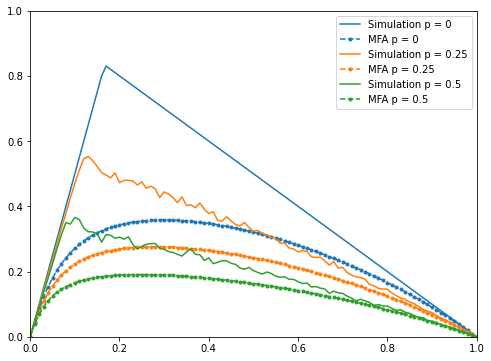

In [22]:
def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

max_speed = 5
p_slows = [0, 0.25, 0.5]
car_densities = np.linspace(0, 1, 101)

mfa_flow_results = {}  # map from p_slow to flow results for all densities

for p_slow in p_slows:
    mfa_flow_results[p_slow] = []
    for density in car_densities:
        # Start from a uniform distribution over speeds
        v = [1/(max_speed + 1)] * (max_speed + 1)
        assert abs(sum(v) - 1) < 1e-6  # Sanity check before
        for i in range(100):  # Run until convergence
            v = mfa(v, density, p_slow)
            assert abs(sum(v) - 1) < 1e-6  # Sanity check after
        mfa_flow_results[p_slow].append(average_flow(v, density))

plt.figure(figsize=(8, 6))
for p, flow in sim_flow_results.items():
    line1 = plt.plot(car_densities, flow, linestyle='-',
             label=f'Simulation p = {p}')
    color = line1[0].get_color()
    plt.plot(car_densities, mfa_flow_results[p], marker='.', linestyle='--',
             color=color, label=f'MFA p = {p}')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

## My code

First, let's make a function that can visualize the grid with intersecting roads.

In [23]:
def make_grid(road_length, road_num):
    """
    
    A function that creates the roads on the grid. 

    Notes:
    The method laternates between making a horizontal and vertical roads (i.e. if there are four roads it will make two horizontal and 
    two vertical roads at symmetrical locations in the grid). For each type of road it also rotates the direction (i.e. if there are two 
    vertical/horizontal roads the first one will move up/to the right and the second one will move down/to the left).

    Attributes:
    -----------
    road_length: int
        The lengths of a road. 
    road_num: int
        The number of roads on the grid. 

    Returns
    -------
    state: a 2-dimensional numpy array of integers. 
        The grid with all roads: -2 is grass, -1 is road. 
    """
    # Create an empty road: -2 means there's grass there so cars can't drive on grass.
    #state = np.full((road_length, road_length), -2, dtype=int)

    state = np.full((road_length, road_length), ' ', dtype=str) # using this just for easier visualization

    vertical_roads = road_num // 2
    horizontal_roads = road_num - vertical_roads

    if horizontal_roads == 1:
        if vertical_roads == 1:
            state[:,road_length//2] = -1
        state[road_length//2,:] = -1
        return state

    horizontal_road_indexes = np.linspace(0, road_length-1, horizontal_roads+1, endpoint=False, dtype = int)[1:]
    vertical_road_indexes = np.linspace(0, road_length-1, vertical_roads+1, endpoint=False, dtype = int)[1:]

    for row in horizontal_road_indexes:
        state[row,:] = -1
    for col in vertical_road_indexes:
        state[:,col] = -1

    return state


print("0 roads")
print(make_grid(10, 0))

print("1 road")
print(make_grid(10, 1))

print("2 roads")
print(make_grid(10, 2))

print("3 roads")
print(make_grid(10, 3))

print("4 roads")
print(make_grid(10, 4))

print("5 roads")
print(make_grid(10, 5))


0 roads
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
1 road
[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['-' '-' '-' '-' '-' '-' '-' '-' '-' '-']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]
2 roads
[[' ' ' ' ' ' ' ' ' ' '-' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '-' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '-' ' '

Now let's incorporate this in our traffic simulation class.

I also changed the `update_optimized()` method in order to:

    - include traffic lights;
    - when the traffic light is green for horizontal roads it's red for vertical roads;
    - made roads that move in different directions. For example the horicontal roads move right or left. 

In [169]:
# Code taken and adapted from Session 9
# Find the original code here: https://nbviewer.org/urls/course-resources.minerva.kgi.edu/uploaded_files/mke/00212840-6806/traffic-simulation-examples.ipynb
class TrafficSimulation:
    """A class to create a traffic simulation
    
    Attributes
    ----------
    road_length: int
        The number of cells in the road. Default: 100.
    road_num: int
        The number of roads. Default: 4.  
    car_density: float
        The fraction of cells that have a car on them. Default: 0.2. 
    prob_slow: float
        The probability that a car will randomly slow down by 1 during an update step. Default: 0.5.
    max_speed: int
         The maximum speed in car cells per update step. Default: 5.
    green_light_time: int
        The time steps that the traffic light for the horizontal roads is green and the time it is red for the vertical (traffic lights are synchronized)
    """


    def __init__(self, road_length=100, road_num = 4, car_density=0.2, prob_slow=0.5,
                 max_speed=5, green_light_time = 10):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Attributes
        ----------
        road_length: int
            The number of cells in the road. Default: 100.
        road_num: int
            The number of roads. Default: 4.  
        car_density: float
            The fraction of cells that have a car on them. Default: 0.2. 
        prob_slow: float
            The probability that a car will randomly slow down by 1 during an update step. Default: 0.5.
        max_speed: int
            The maximum speed in car cells per update step. Default: 5.
        green_light_time: int
            The time steps that the traffic light for the horizontal roads is green and the time it is red for the vertical (traffic lights are synchronized)
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.step_counter = 0
        self.road_num = road_num
        self.traffic_light_horizontal = True # If true then it's a green lights for the cars on horizontal roads
        self.green_light_time = green_light_time
        

        ### CHANGED create the grid
        self.state, self.horizontal_roads_rows, self.vertical_roads_columns = self.make_grid(self.road_length, self.road_num)

        # Store the intersection points
        self.intersections = []
        for row in self.horizontal_roads_rows:
            for col in self.vertical_roads_columns:
                self.intersections.append((row,col))
                
        x_road_indexes, y_road_indexes = np.where(self.state == -1)
        
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            len(x_road_indexes),
            size=int(round(car_density * self.road_length * self.road_num)),
            replace=False)
        
        
        # Give each car a random initial speed from 0 to max_speed
        for i in range(len(random_indexes)):
            self.state[x_road_indexes[random_indexes[i]]][y_road_indexes[random_indexes[i]]] =  np.random.randint(
            0, self.max_speed + 1, size=1)

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def make_grid(self, road_length, road_num):
        """
    
        A function that creates the roads on the grid. 

        Notes:
        The method laternates between making a horizontal and vertical roads (i.e. if there are four roads it will make two horizontal and 
        two vertical roads at symmetrical locations in the grid). For each type of road it also rotates the direction (i.e. if there are two 
        vertical/horizontal roads the first one will move up/to the right and the second one will move down/to the left).

        Attributes:
        -----------
        road_length: int
            The lengths of a road. 
        road_num: int
            The number of roads on the grid. 

        Returns
        -------
        state: a 2-dimensional numpy array of integers. 
            The grid with all roads: -2 is grass, -1 is road. 
        """
    
        # Create an empty road: -2 means there's grass there so cars can't drive on grass.
        state = np.full((road_length, road_length), -2, dtype=int)

        # Get number of each road type. 
        vertical_roads = road_num // 2
        horizontal_roads = road_num - vertical_roads
        
        # Store the indexes of each road. 
        vertical_roads_indexes = []
        horizontal_roads_indexes = []

        # If there is only a single horizontal road. 
        if horizontal_roads == 1:
            # If there is only a single vertical road. 
            if vertical_roads == 1:
                state[:,road_length//2] = -1
                vertical_roads_indexes.append(road_length//2)
                
            state[road_length//2,:] = -1
            horizontal_roads_indexes.append(road_length//2)
            
            return state, horizontal_roads_indexes, vertical_roads_indexes

        # If there are more than one horizontal and verticle roads then we position them symmetrically on the grid. 
        horizontal_road_indexes = np.linspace(0, road_length-1, horizontal_roads+1, endpoint=False, dtype = int)[1:]
        vertical_road_indexes = np.linspace(0, road_length-1, vertical_roads+1, endpoint=False, dtype = int)[1:]

        for row in horizontal_road_indexes:
            state[row,:] = -1
        for col in vertical_road_indexes:
            state[:,col] = -1

        return state, horizontal_road_indexes, vertical_road_indexes

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.

        Parameters
        ----------
        optimized: Bool
            If True, then call the optimized update function. 
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1


    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        
        previous_state = copy.deepcopy(self.state)
        # Get the location of each car
        x_car_indexes, y_car_indexes = np.where(self.state >= 0)
        
        # If there are no cars, we have nothing to update
        if len(x_car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # If true then it's green for horizontal lanes so they keep moving
        if self.traffic_light_horizontal: 
            
            # If traffic light just changes then, update vertical roads first to clear the intersections. 
            if self.step_counter % self.green_light_time == 0:
                self._update_vertical_segments(state = previous_state)
            
            direction_right = True # road moves in right direction when True
            
            # Update all horizontal roads
            for horizontal_row in self.horizontal_roads_rows:
                
                # Get road
                if direction_right: 
                    current_road = self.state[horizontal_row][:]
                else:
                    current_road = self.state[horizontal_row][::-1]
                
                # Update road
                current_road = self.update_road(road = current_road)
                
                # Update the state
                if direction_right: 
                    self.state[horizontal_row] = current_road
                
                else:
                    self.state[horizontal_row] = current_road[::-1]
                
                direction_right = not direction_right
                 
            # We need to also update the vertical roads (cars can move up until the traffic light point)
            if self.step_counter % self.green_light_time != 0:
                self._update_vertical_segments(state = self.state)
                    
        else: #Green for vertical lanes
            
            # If traffic light just changes then, update horizontal roads first to clear the intersections. 
            if self.step_counter % self.green_light_time == 0:
                self._update_horizontal_segments(state = previous_state)
            
            direction_up = True # cars on road move towards the top of the screen
            
            # Update each vertical road
            for vertical_column in self.vertical_roads_columns:
                
                # Get road
                if direction_up:                     
                    current_road = self.state[:, vertical_column]
                    current_road  = current_road [::-1]
                    
                else:
                    current_road = self.state[:, vertical_column]
                    
                # Update road
                current_road = self.update_road(road = current_road)
                    
                if direction_up: 
                    self.state[:, vertical_column] = current_road[::-1]
                else:
                    self.state[:, vertical_column] = current_road
                    
                direction_up = not direction_up
            
            # Update horizontal roads up until the traffic lights. 
            if self.step_counter % self.green_light_time != 0:
                self._update_horizontal_segments(state = self.state)
            
        # Update traffic flow history
        traffic = 0
        for row in self.horizontal_roads_rows:
            road = self.state[row,:]
            
            traffic += np.sum(road[road>0])
            
        for col in self.vertical_roads_columns:
            road = self.state[:, col]
            
            traffic += np.sum(road[road>0])

        self.average_traffic_flow.append(traffic / (self.road_length*self.road_num - self.road_num//2))

        self.time_step += 1

        # Update step counter
        self.step_counter += 1
        
        # Change the traffic light color if time is up. 
        if self.step_counter % self.green_light_time == 0:
            self.traffic_light_horizontal = not self.traffic_light_horizontal
        
    def _update_vertical_segments(self, state): 
        
        """A function to update the different segments of a vertical road when the traffic light is red for them
        
        Parameters
        ----------
        state: 2-dimensional numpy array of integers
            The current state to be updated. 
        
        Returns
        -------
        None
        """
        
        # Updating vertical segments
        
        direction_up = True # cars on road move towards the top of the screen

        for vertical_column in self.vertical_roads_columns:
            
            # Get vertical road
            current_road = copy.deepcopy(state[:, vertical_column])

            if direction_up: 
                current_road = current_road[::-1]
            
            #Get each segment of the road
            start_index = 0

            for i in range(len(self.horizontal_roads_rows)):
                
                # Wrap around the last segment of the road with the first segment of roads 
                if start_index == 0:
                    road_segment = current_road[self.horizontal_roads_rows[-1] + 1 : ]
                    
                    end_length = len(road_segment)
                
                    road_segment = np.concatenate((road_segment, current_road[start_index : self.horizontal_roads_rows[0]]))
                
                # Otherwise just get the current segment
                else:
                    road_segment = current_road[start_index : self.horizontal_roads_rows[i]]
                
                updated_road_segment = self._update_vertical_segments_road(road_segment)
                
                # Update the current road
                if start_index == 0:
                    current_road[0 : self.horizontal_roads_rows[0]] = updated_road_segment[end_length:]
                    current_road[self.horizontal_roads_rows[-1] + 1 : ] = updated_road_segment[0:end_length]
                else:
                    current_road[start_index:self.horizontal_roads_rows[i]] = updated_road_segment
                
                # Update start index of the next segment. 
                start_index = self.horizontal_roads_rows[i] + 1

            if direction_up: 
                current_road = current_road[::-1]
                
                
            # Update cars from first segment
            self.state[self.horizontal_roads_rows[-1]+1:, vertical_column] = current_road[self.horizontal_roads_rows[-1]+1:]
            # Update cars from second segment
            self.state[self.horizontal_roads_rows[0]+1:self.horizontal_roads_rows[-1], vertical_column] = current_road[self.horizontal_roads_rows[0]+1:self.horizontal_roads_rows[-1]]
            # Update cars from last segment
            self.state[0:self.horizontal_roads_rows[0], vertical_column] = current_road[0:self.horizontal_roads_rows[0]]      

            direction_up = not direction_up


    def _update_horizontal_segments(self, state): 
        
        """A function to update the different segments of a horizontal road when the traffic light is red for them
        
        Parameters
        ----------
        state: 2-dimensional numpy array of integers
            The current state to be updated. 
        
        Returns
        -------
        None
        
        """
        
        direction_right = True # cars on road move towards the top of the screen

        for horizontal_row in self.horizontal_roads_rows:
            
            # print("🛣️ Updating a new horizontal road")
            #  Updating a new horizontal road
            
            # Get horizontal road
            current_road = copy.deepcopy(state[horizontal_row, :])
            # print(current_road)

            # If moving left reverse the direction
            if not direction_right: 
                current_road = current_road[::-1]
            
            #Get each segment of the road
            start_index = 0

            for i in range(len(self.vertical_roads_columns)):
                
                # Wrap around the last with the first segment of roads. 
                if start_index == 0:
                    road_segment = current_road[self.vertical_roads_columns[-1] + 1 : ]
                    
                    end_length = len(road_segment)
                
                    road_segment = np.concatenate((road_segment, current_road[start_index : self.vertical_roads_columns[0]]))
                else:
                    road_segment = current_road[start_index : self.vertical_roads_columns[i]]
                

                # Update the segment
                updated_road_segment = self._update_vertical_segments_road(road_segment)
                
                # Reflect the update in the current road
                if start_index == 0:
                    current_road[0 : self.vertical_roads_columns[0]] = updated_road_segment[end_length:]
                    current_road[self.vertical_roads_columns[-1] + 1 : ] = updated_road_segment[0:end_length]
                else:
                    current_road[start_index:self.vertical_roads_columns[i]] = updated_road_segment
                
                start_index = self.vertical_roads_columns[i] + 1

            # Update the state of the simulation. 
            if not direction_right: 
                # Reverse list if moving in left direction.
                current_road = current_road[::-1]

            # Update cars from first segment
            self.state[horizontal_row, 0:self.vertical_roads_columns[0]] = current_road[0:self.vertical_roads_columns[0]]
            # Update cars from second segment
            self.state[horizontal_row, self.vertical_roads_columns[0]+1:self.vertical_roads_columns[-1]] = current_road[self.vertical_roads_columns[0]+1:self.vertical_roads_columns[-1]]
            # Update cars from last segment
            self.state[horizontal_row, self.vertical_roads_columns[-1]+1:] = current_road[self.vertical_roads_columns[-1]+1:]

            direction_right = not direction_right
            
    def update_road(self, road, segments = False):
        
        '''
        Update a road on the grid (1 step that applies the update rules of acceleration and deccelaration). 

        Parameters
        ----------
        road: 1-dimensional numpy array
            The road to be updated. 
        segments: bool
            If true, then we are updating a segment of a road instead of a whole road. 
        '''
        # Get the location of each car
        car_indexes = np.where(road >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            
            return road

        if not segments:
             # Get the speed of each cars
            car_speeds = road[car_indexes]
        else:
            car_speeds = road[car_indexes]
            car_speeds = car_speeds[len(road)-self.horizontal_roads_row[0]:]

           
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(np.concatenate((car_indexes,
                                [car_indexes[0] + self.road_length])))
        
        
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        
        car_indexes %= len(road)
        road.fill(-1)
        road[car_indexes] = car_speeds

        return road
                    
        
    
    def _update_vertical_segments_road(self, road):
        
        '''
        This method is used to update the specific road tiles of a road segment of a road. It's a subroutine of updating roads when theri traffic light is red. 

        Parameters
        ----------
        road: 1-dimensional numpy array
            The road to be updated. 
        '''
        # Get the location of each car
        car_indexes = np.where(road >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            
            return road

         # Get the speed of each cars
        car_speeds = road[car_indexes]

           
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(np.concatenate((car_indexes,
                                [car_indexes[0] + self.road_length])))
            
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        
        # Move cars forward using their new speeds
        car_indexes = np.minimum(car_indexes + car_speeds, len(road) - 1)
        
        road.fill(-1)
        road[car_indexes] = car_speeds
        
        if road[-1] > 0 : 
            road[-1] = 0 # if there is a car at the traffic light it needs to stop immediately

        return road

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for row in self.state:
            print(''.join(' ' if x == -2 else '.'  if x == -1 else str(x) for x in row))

    # Initialize plot for visualizations
    def initialize(self):
        """ This method initializes the plot"""
        self.figure, self.axes = plt.subplots()

    def observe(self):
        """A method used to plot the state of the configuration on the plot at each step"""
        
        import matplotlib.colors as colors

        # Create a custom color map
        blues = plt.cm.Blues(np.linspace(0, 1, self.max_speed))
        
        green = plt.cm.Greens(np.linspace(0.9, 0.9, 1))
        
        gray = [0.5, 0.5, 0.5, 1]

        # Combine the colors for the cars and background into a single colormap
        cmap_colors = np.vstack((green, gray, blues))
        custom_cmap = colors.ListedColormap(cmap_colors)

        # Plot the color map
        plot = self.axes.imshow(self.state, vmin=-2, vmax=self.max_speed, cmap=custom_cmap)
        self.axes.set_title(f'State at step {self.step_counter}')
        
        # Add traffic lights
        for row in self.horizontal_roads_rows:
            for col in self.vertical_roads_columns:
                
                if self.traffic_light_horizontal: color = 'green'
                else: color = 'red'
            
                self.axes.scatter(col, row, s=100/self.road_length, c = color)

        return plot

In [47]:
sim = TrafficSimulation(
    road_length=10, car_density=0, max_speed=1, prob_slow=0, green_light_time = 5)

sim.state[3][0] = 0
sim.state[6][9] = 0
sim.display()
make_animation(sim, total_frames=30, steps_per_frame=1)

   .  .   
   .  .   
   .  .   
0.........
   .  .   
   .  .   
.........0
   .  .   
   .  .   
   .  .   


100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


<Figure size 640x480 with 0 Axes>

In [48]:
sim = TrafficSimulation(
    road_length=10, car_density=0, max_speed=1, prob_slow=0, green_light_time = 5)

sim.state[9][3] = 0
sim.state[0][6] = 0

make_animation(sim, total_frames=15, steps_per_frame=1)

100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


<Figure size 640x480 with 0 Axes>

In [49]:
# Turning left/right
sim = TrafficSimulation(
    road_length=10, car_density=0, max_speed=1, prob_slow=0, green_light_time = 3)

sim.state[9][3] = 0
sim.state[0][6] = 0
sim.state[3][0] = 0

make_animation(sim, total_frames=15, steps_per_frame=1)

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


<Figure size 640x480 with 0 Axes>

In [50]:
# Test state and step counter
sim = TrafficSimulation(
    road_length=10, car_density=0.3, max_speed=5, prob_slow=0.5, green_light_time = 1)

print(sim.state)
for i in range(2):
#     sim.display()
    sim.update(optimized=True)
    
print(sim.step_counter)

[[-2 -2 -2 -1 -2 -2 -1 -2 -2 -2]
 [-2 -2 -2 -1 -2 -2 -1 -2 -2 -2]
 [-2 -2 -2 -1 -2 -2 -1 -2 -2 -2]
 [-1  5 -1 -1 -1 -1  3  5 -1  3]
 [-2 -2 -2  5 -2 -2  1 -2 -2 -2]
 [-2 -2 -2 -1 -2 -2  2 -2 -2 -2]
 [-1  3  5 -1 -1 -1 -1 -1 -1  4]
 [-2 -2 -2  5 -2 -2  5 -2 -2 -2]
 [-2 -2 -2 -1 -2 -2 -1 -2 -2 -2]
 [-2 -2 -2 -1 -2 -2 -1 -2 -2 -2]]
2


In [51]:
# Test average flow
sim = TrafficSimulation(
    road_length=10, car_density=0, max_speed=5, prob_slow=0.5, green_light_time = 1)

for i in range(50):
#     sim.display()
    sim.update(optimized=True)
    
print(sim.step_counter)
print(sim.average_traffic_flow) # should be 0 since there are no cars

0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [52]:
sim = TrafficSimulation(
    road_length=50, car_density=0.8, max_speed=5, prob_slow=0, green_light_time = 10)


make_animation(sim, total_frames=50, steps_per_frame=1)

100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


<Figure size 640x480 with 0 Axes>

In [53]:
sim = TrafficSimulation(
    road_length=10, car_density=0.6, max_speed=5, prob_slow=0, green_light_time = 10)



make_animation(sim, total_frames=50, steps_per_frame=1)

100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


<Figure size 640x480 with 0 Axes>

## Analysis

In [74]:
# Average traffic flow line plot - one instance converging to a state
from tqdm import tqdm
sim = TrafficSimulation(
    road_length=100, car_density=0.3, max_speed=4, prob_slow=0.1, green_light_time = 55)

steps = []
traffic_flow = []
for i in range(1000):
    sim.update(optimized=True)
    steps.append(i)
    
traffic_flow = sim.average_traffic_flow

Text(0, 0.5, 'Average Traffic Flow')

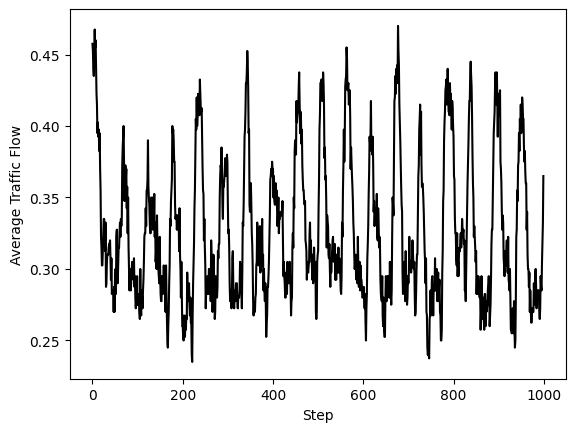

In [75]:
plt.plot(steps, traffic_flow, color = 'black')
plt.xlabel("Step")
plt.ylabel("Average Traffic Flow")

In [76]:
# Histogram of verage traffic flow - 1000 simulations (data points) that are simulated for 100 steps each. 
traffic_flow = []

for i in range(1000):
    sim = TrafficSimulation(
        road_length=100, car_density=0.3, max_speed=4, prob_slow=0.1, green_light_time = 55)
    
    for j in range(100):
        sim.update(optimized=True)
        
    traffic_flow.append(sim.average_traffic_flow[-1])

Sample mean: 0.29
95% confidence interval of population mean: [0.289, 0.291]


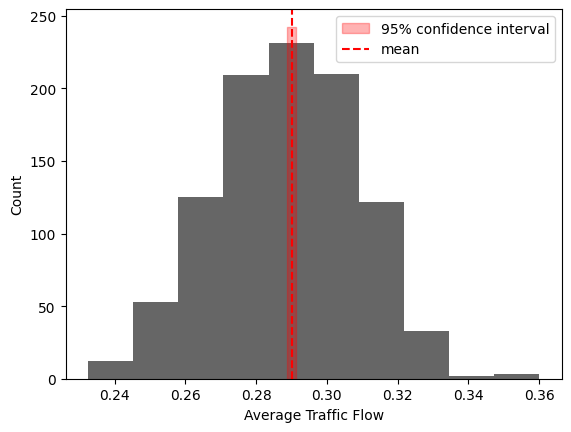

In [103]:
import scipy.stats as sts

plt.ylabel("Count")
plt.xlabel("Average Traffic Flow")

# Add some statistics

# 95% CI - reused code from last assignment
# Mean 95% CI
m = np.mean(traffic_flow)
m_approx = round(m, 2)
print('Sample mean:', m_approx)

t = sts.sem(traffic_flow)
t_approx = t#round(t, 2)

print('95% confidence interval of population mean:', [ round(m_approx - 1.96*t_approx, 3), round(m_approx + 1.96*t_approx,3)])

confidence_interval_95 =  [np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/100, np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/100]

plt.hist(traffic_flow, color = 'black', alpha = 0.6)

ylim = plt.ylim()
plt.fill_between([m_approx - 1.96*t_approx, m_approx + 1.96*t_approx], 0, ylim[1], color = 'red', alpha = 0.3, label = '95% confidence interval')
# Add a line for the mean
plt.axvline(m_approx, color = 'red', linestyle='--', label = 'mean')

plt.legend()
plt.show()
                                      
                                      

In [206]:
# Error bar plot for different traffic light times

# This takes VERY long - you can make the number of trials smaller to make it faster

# Initialize lists to store the data for the plot
x_axis = []
traffic_flow = [] # y axis
errors = [] # error bar data - it's a list of tuples

# The traffic light values to test out. 
traffic_lights_time_min = 1
traffic_lights_time_max = 70

# For many different values for the timing of the traffic lights. 
for green_light_time in tqdm(range(traffic_lights_time_min, traffic_lights_time_max)):
    

    x_axis.append(green_light_time)

    # Store data for all trials and then I take the average of the trials for the final plot. 
    data = []
    
    trials = 100

    for trial in range(trials):
        sim = TrafficSimulation(
        road_length=100, car_density=0.3, max_speed=4, prob_slow=0.1, green_light_time = green_light_time)

        update_steps = 200

        for j in range(update_steps):
            sim.update(optimized=True)
        data.append(sim.average_traffic_flow[-1])
    
    traffic_flow.append(np.mean(data))
    errors.append((np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/(trials**0.5), np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/(trials**0.5)))


    

100%|██████████| 69/69 [10:15<00:00,  8.92s/it]


Text(0, 0.5, 'Average traffic flow')

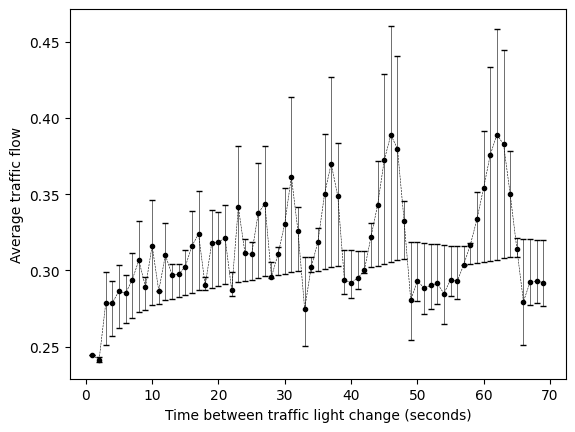

In [209]:
y_axis_errors = [[], []]

for i in range(len(errors)):
    y_axis_errors[0].append(abs(errors[i][0]-traffic_flow[i]))
    y_axis_errors[1].append(abs(errors[i][1]-traffic_flow[i]))

plt.errorbar(x_axis, traffic_flow, yerr = y_axis_errors, color='black', marker='o', markersize = 3, capsize=2, linestyle='--', linewidth=0.4)
plt.xlabel('Time between traffic light change (seconds)')
plt.ylabel('Average traffic flow')

In [211]:
# Heat map of speed limit and time between traffic light change
# Code adapted from Session 19 - https://sle-collaboration.minervaproject.com/?id=5eac119d-31c8-4e64-a741-d48420edc750&userId=10834&name=Vicki+Petrova&avatar=https%3A//s3.us-east-1.amazonaws.com/picasso.fixtures/Victoria_Petrova_10834_2020-09-11T21%3A29%3A05.741Z&noPresence=1&readOnly=1&isInstructor=0&signature=0c2739d5c5a0a4f5413ab04e7000a5050c53690c02edad53500d0da2c60c303c

# Array with infection_probability values that vary between 0 and 1

# Array with green_light_time values that vary between 1 and 50
green_light_time = list(range(1, 85))
green_light_time = np.array(green_light_time, dtype=np.int64)

# Array with max_speed_limit values that vary between 1 and 20
max_speed_limit = list(range(1, 20))
max_speed_limit = np.array(max_speed_limit, dtype=np.int64)


# Run the simulation for a maximum of 1000 steps and record the average traffic flow
results = np.empty((len(green_light_time), len(max_speed_limit)))
for i, time in enumerate(green_light_time):
    for j, speed in enumerate(max_speed_limit):

        sim = TrafficSimulation(
            road_length=100, car_density=0.3, max_speed = speed, prob_slow=0.1, green_light_time = time)

        for step in range(200):
            sim.update()

            # Occasionally check whether the traffic has stopped. This speeds
            # things up a bit since there could be a traffic jam
            if (step % 100 == 0) and (sim.average_traffic_flow[-1] == 0):
                break
        results[i, j] = sim.average_traffic_flow[-1]
        del sim




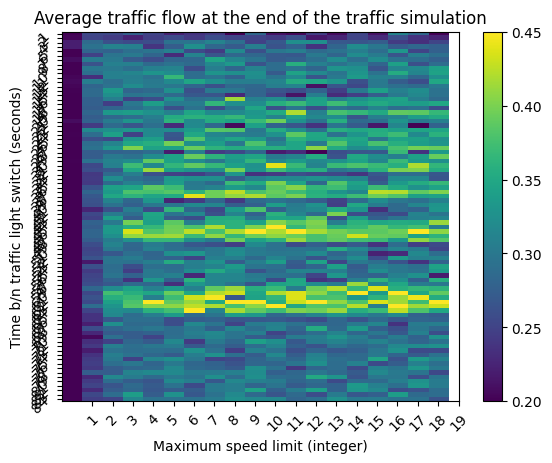

In [235]:
## Plotting the results
fig = plt.figure()

# ax = plt.gca()

plt.title('Average traffic flow at the end of the traffic simulation')
plt.imshow(results, vmin=0.2, vmax=0.45, aspect='auto')


plt.xticks(list(range(1, 20)), max_speed_limit, rotation=45)

# plt.setp(ax.xaxis.get_xticklabels()[::2], visible=False)

# for label in fig.ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)

plt.yticks(range(len(green_light_time)), green_light_time, rotation = 45)

plt.xlabel('Maximum speed limit (integer)')
plt.ylabel('Time b/n traffic light switch (seconds)')
plt.colorbar()
plt.show()

In [236]:
## Speed limit error plot
# Error bar plot for different traffic light times

# This takes VERY long - you can make the number of trials smaller to make it faster

# Initialize lists to store the data for the plot
x_axis = []
traffic_flow = [] # y axis
errors = [] # error bar data - it's a list of tuples

# The traffic light values to test out. 

speed_limit = 20

# For many different values for the timing of the traffic lights. 
for max_speed in tqdm(range(1, speed_limit)):
    

    x_axis.append(max_speed)

    # Store data for all trials and then I take the average of the trials for the final plot. 
    data = []
    
    trials = 100

    for trial in range(trials):
        sim = TrafficSimulation(
        road_length=100, car_density=0.3, max_speed=max_speed, prob_slow=0.1, green_light_time = 62)

        update_steps = 200

        for j in range(update_steps):
            sim.update(optimized=True)
        data.append(sim.average_traffic_flow[-1])
    
    traffic_flow.append(np.mean(data))
    errors.append((np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/(trials**0.5), np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/(trials**0.5)))


    

100%|██████████| 19/19 [02:56<00:00,  9.27s/it]


Text(0, 0.5, 'Average traffic flow')

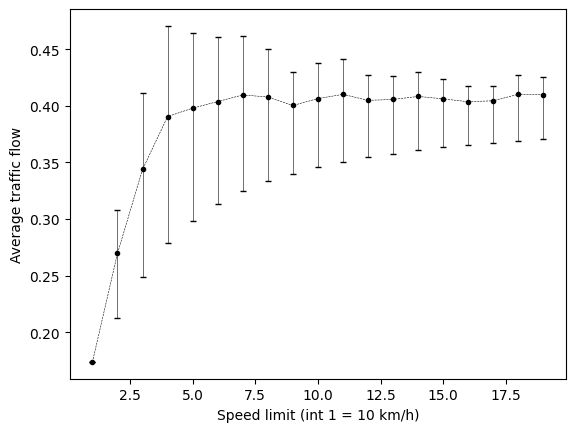

In [237]:
y_axis_errors = [[], []]

for i in range(len(errors)):
    y_axis_errors[0].append(abs(errors[i][0]-traffic_flow[i]))
    y_axis_errors[1].append(abs(errors[i][1]-traffic_flow[i]))

plt.errorbar(x_axis, traffic_flow, yerr = y_axis_errors, color='black', marker='o', markersize = 3, capsize=2, linestyle='--', linewidth=0.4)
plt.xlabel('Speed limit (int 1 = 10 km/h)')
plt.ylabel('Average traffic flow')

# Simulation with no traffic lights

In [183]:
# Code taken and adapted from Session 9
# Find the original code here: https://nbviewer.org/urls/course-resources.minerva.kgi.edu/uploaded_files/mke/00212840-6806/traffic-simulation-examples.ipynb
class TrafficSimulationNoLights:

    def __init__(self, road_length=100, road_num = 4, car_density=0.2, prob_slow=0.5,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.step_counter = 0
        self.road_num = road_num
        self.traffic_light_horizontal = True # If true then it's a green lights for the cars on horizontal roads
        self.green_light_time = green_light_time
        

        ### CHANGED create the grid
        self.state, self.horizontal_roads_rows, self.vertical_roads_columns = self.make_grid(self.road_length, self.road_num)

        # Store the intersection points
        self.intersections = []
        for row in self.horizontal_roads_rows:
            for col in self.vertical_roads_columns:
                self.intersections.append((row,col))
                
        x_road_indexes, y_road_indexes = np.where(self.state == -1)
        

        # Choose random locations to place cars
        random_indexes = np.random.choice(
            len(x_road_indexes),
            size=int(round(car_density * self.road_length * self.road_num)),
            replace=False)
        
        
        # Give each car a random initial speed from 0 to max_speed
        for i in range(len(random_indexes)):
            self.state[x_road_indexes[random_indexes[i]]][y_road_indexes[random_indexes[i]]] =  np.random.randint(
            0, self.max_speed + 1, size=1)

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def make_grid(self, road_length, road_num):
    
        # Create an empty road: -2 means there's grass there so cars can't drive on grass.
        state = np.full((road_length, road_length), -2, dtype=int)

        vertical_roads = road_num // 2
        horizontal_roads = road_num - vertical_roads
        
        vertical_roads_indexes = []
        horizontal_roads_indexes = []

        if horizontal_roads == 1:
            if vertical_roads == 1:
                state[:,road_length//2] = -1
                vertical_roads_indexes.append(road_length//2)
                
            state[road_length//2,:] = -1
            horizontal_roads_indexes.append(road_length//2)
            
            return state, horizontal_roads_indexes, vertical_roads_indexes

        horizontal_road_indexes = np.linspace(0, road_length-1, horizontal_roads+1, endpoint=False, dtype = int)[1:]
        vertical_road_indexes = np.linspace(0, road_length-1, vertical_roads+1, endpoint=False, dtype = int)[1:]

        for row in horizontal_road_indexes:
            state[row,:] = -1
        for col in vertical_road_indexes:
            state[:,col] = -1

        return state, horizontal_road_indexes, vertical_road_indexes

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (
                    (self.state[i] > 0) and
                    (np.random.uniform() < self.prob_slow)
                ):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = np.full(self.road_length, -1, dtype=int)
        for i in range(self.road_length):
            cell = self.state[i]
            if cell != -1:
                new_state[(i + cell) % self.road_length] = cell
        self.state = new_state

        # Update average traffic flow history
        self.average_traffic_flow.append(
            sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1


    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        
        previous_state = copy.deepcopy(self.state)
        # Get the location of each car
        x_car_indexes, y_car_indexes = np.where(self.state >= 0)
        
        # If there are no cars, we have nothing to update
        if len(x_car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        
        direction_right = True # road moves in right direction when True
        
        for horizontal_row in self.horizontal_roads_rows:
            
            if direction_right: 
                current_road = self.state[horizontal_row][:]
                #print("Road moving right", current_road)
            else:
                current_road = self.state[horizontal_row][::-1]
                #print("Road moving left", current_road)
                
            
            current_road = self.update_road(road = current_road)
                
            if direction_right: 
                self.state[horizontal_row] = current_road
            
            else:
                self.state[horizontal_row] = current_road[::-1]
            
            direction_right = not direction_right
                
#             print("Updated horizontal")
#             self.display()
              
        
        direction_up = True # cars on road move towards the top of the screen
        
        for vertical_column in self.vertical_roads_columns:
            
            if direction_up:                     
                current_road = self.state[:, vertical_column]
                current_road  = current_road [::-1]
                #print("Road moving up", current_road)
                
            else:
                current_road = self.state[:, vertical_column]
                #print("Road moving down", current_road)
                
            
            current_road = self.update_road(road = current_road)
                
            if direction_up: 
                self.state[:, vertical_column] = current_road[::-1]
            
            else:
                self.state[:, vertical_column] = current_road
                
            direction_up = not direction_up
            
        # Update traffic flow history
        traffic = 0
        for row in self.horizontal_roads_rows:
            road = self.state[row,:]
            
            traffic += np.sum(road[road>0])
            
        for col in self.vertical_roads_columns:
            road = self.state[:, col]
            
            traffic += np.sum(road[road>0])

        self.average_traffic_flow.append(traffic / (self.road_length*self.road_num - self.road_num//2))

        self.time_step += 1

        # Update step counter
        self.step_counter += 1
        
        
    
            
    def update_road(self, road, segments = False):
        
        '''
        Update a road on the grid (1 step)
        '''
        # Get the location of each car
        car_indexes = np.where(road >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            
            return road

        if not segments:
             # Get the speed of each cars
            car_speeds = road[car_indexes]
        else:
            car_speeds = road[car_indexes]
            car_speeds = car_speeds[len(road)-self.horizontal_roads_row[0]:]

           
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(np.concatenate((car_indexes,
                                [car_indexes[0] + self.road_length])))
        
        
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        
        # Move cars forward using their new speeds
        car_indexes += car_speeds
        
#         if not segments:
        car_indexes %= len(road)
        road.fill(-1)
        road[car_indexes] = car_speeds

        return road

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for row in self.state:
            print(''.join(' ' if x == -2 else '.'  if x == -1 else str(x) for x in row))

    # Initialize plot for visualizations
    def initialize(self):
        """ This method initializes the plot"""
        self.figure, self.axes = plt.subplots()

    def observe(self):
        """A method used to plot the state of the configuration on the plot at each step"""
        
        import matplotlib.colors as colors

        # Create a custom color map
        blues = plt.cm.Blues(np.linspace(0, 1, self.max_speed))
        
        green = plt.cm.Greens(np.linspace(0.9, 0.9, 1))
        
        
        gray = [0.5, 0.5, 0.5, 1]
        # Combine the colors for the cars and background into a single colormap
        cmap_colors = np.vstack((green, gray, blues))
        custom_cmap = colors.ListedColormap(cmap_colors)

        plot = self.axes.imshow(self.state, vmin=-2, vmax=self.max_speed, cmap=custom_cmap)
        self.axes.set_title(f'State at step {self.step_counter}')
        
        for row in self.horizontal_roads_rows:
            for col in self.vertical_roads_columns:
                
                if self.traffic_light_horizontal: color = 'green'
                else: color = 'red'
            
                self.axes.scatter(col, row, s=100/self.road_length, c = color)

        return plot

In [195]:
# Average traffic flow line plot - one instance converging to a state
from tqdm import tqdm
sim = TrafficSimulationNoLights(
    road_length=100, car_density=0.3, max_speed=4, prob_slow=0.1)

steps = []
traffic_flow = []
for i in tqdm(range(1000)):
    sim.update(optimized=True)
    steps.append(i)
    
traffic_flow = sim.average_traffic_flow

100%|██████████| 1000/1000 [00:00<00:00, 3717.67it/s]


Text(0, 0.5, 'Average Traffic Flow')

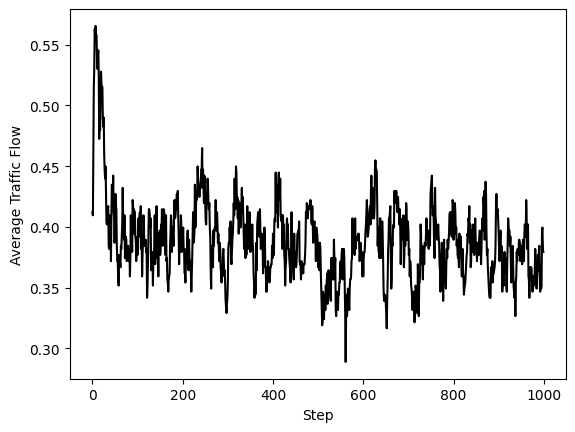

In [196]:
plt.plot(steps, traffic_flow, color = 'black')
plt.xlabel("Step")
plt.ylabel("Average Traffic Flow")

In [187]:
# Histogram of verage traffic flow - 1000 simulations (data points) that are simulated for 100 steps each. 
traffic_flow = []

for i in tqdm(range(1000)):
    sim = TrafficSimulationNoLights(
        road_length=100, car_density=0.3, max_speed=4, prob_slow=0.1)
    
    for j in range(100):
        sim.update(optimized=True)
        
    traffic_flow.append(sim.average_traffic_flow[-1])

100%|██████████| 1000/1000 [00:26<00:00, 37.16it/s]


Sample mean: 0.39
95% confidence interval of population mean: [0.388, 0.392]


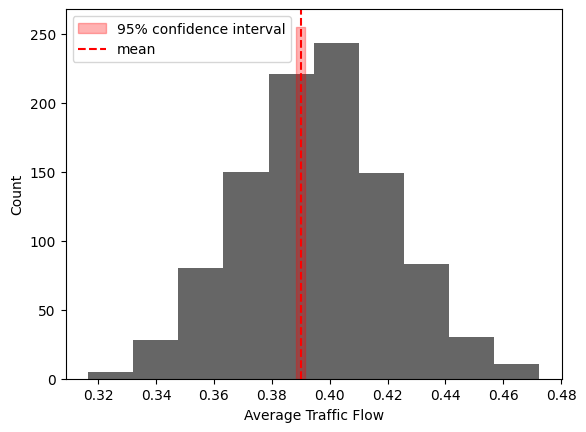

In [188]:
import scipy.stats as sts

plt.ylabel("Count")
plt.xlabel("Average Traffic Flow")

# Add some statistics

# 95% CI - reused code from last assignment
# Mean 95% CI
m = np.mean(traffic_flow)
m_approx = round(m, 2)
print('Sample mean:', m_approx)

t = sts.sem(traffic_flow)
t_approx = t#round(t, 2)

print('95% confidence interval of population mean:', [ round(m_approx - 1.96*t_approx, 3), round(m_approx + 1.96*t_approx,3)])

confidence_interval_95 =  [np.mean(traffic_flow) - 1.96*np.std(traffic_flow)/100, np.mean(traffic_flow) + 1.96*np.std(traffic_flow)/100]

plt.hist(traffic_flow, color = 'black', alpha = 0.6)

ylim = plt.ylim()
plt.fill_between([m_approx - 1.96*t_approx, m_approx + 1.96*t_approx], 0, ylim[1], color = 'red', alpha = 0.3, label = '95% confidence interval')
# Add a line for the mean
plt.axvline(m_approx, color = 'red', linestyle='--', label = 'mean')

plt.legend()
plt.show()
                                                            

## Theoretical Analysis

In [253]:
trials = 50

p_slows = [0, 0.25, 0.5]
car_densities = np.linspace(0, 0.95, 96)
traffic_flow = {}

for p_slow in tqdm(p_slows):
    traffic_flow[p_slow] = []

    for density in car_densities:
        
        data = []
        
        for trial in range(trials):
            sim = TrafficSimulation(
                road_length=100, car_density=density, max_speed=4, prob_slow=p_slow, green_light_time = 62)
            
            update_steps = 200

            for j in range(update_steps):
                sim.update(optimized=True)

            data.append(sim.average_traffic_flow[-1])

        traffic_flow[p_slow].append(np.mean(data))



    

100%|██████████| 3/3 [21:51<00:00, 437.29s/it]


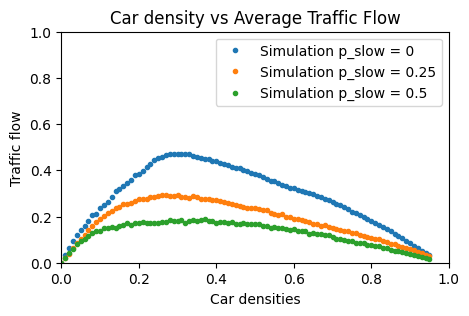

In [254]:
plt.figure(figsize=(5, 3))
plt.title("Car density vs Average Traffic Flow")
for p, flow in traffic_flow.items():
    plt.plot(car_densities, traffic_flow[p], '.', label=f'Simulation p_slow = {p}')
plt.xlabel('Car densities')
plt.ylabel('Traffic flow')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [255]:
# Code adapted from class
import numpy as np
import matplotlib.pyplot as plt

def mfa(v, density, p_slow):
    '''
    Calculate the updated distribution over speeds given the current
    distribution by applying the MFA traffic rules.

    Inputs:
    
        v (list of float) The car speed probability vector. v[i] is the
        probability that a car is moving at speed i.

        density (float) The average number of cars per cell on the road.
        
        p_slow (float) The probability of random slow-down.
    
    Returns: A new, updated car speed probability vector.
    '''
    v_max = len(v) - 1
    new_v = [0] * len(v)  # The updated speed probability vector
    for v_from in range(v_max + 1):
        
        # Current speed, will be updated below
        speed = v_from
        
        # Accelerate
        if speed < v_max:
            speed += 1
        
        # Brake when there is a car in front at each distance from 1 to speed
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = (1-density)**(distance-1) * density
            
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance
        
        # No cars in front up to distance == speed
        new_v[speed] += v[v_from] * (1-density)**speed * (1-p_slow)
        new_v[speed-1] += v[v_from] * (1-density)**speed * p_slow
        
    return new_v

In [256]:
def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

max_speed = 5
p_slows2 = [0, 0.25, 0.5]
car_densities2 = np.linspace(0, 1, 101)

mfa_flow_results = {}  # map from p_slow to flow results for all densities

for p_slow in p_slows2:
    mfa_flow_results[p_slow] = []
    for density in car_densities2:
        # Start from a uniform distribution over speeds
        v = [1/(max_speed + 1)] * (max_speed + 1)
        assert abs(sum(v) - 1) < 1e-6  # Sanity check before
        for i in range(100):  # Run until convergence
            v = mfa(v, density, p_slow)
            assert abs(sum(v) - 1) < 1e-6  # Sanity check after
        mfa_flow_results[p_slow].append(average_flow(v, density))


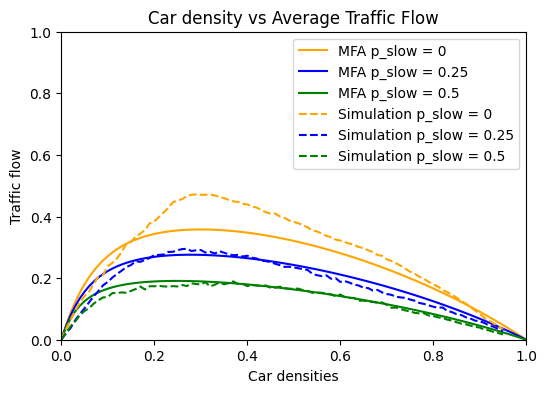

In [277]:
plt.figure(figsize=(6, 4))
plt.title("Car density vs Average Traffic Flow")
plt.xlabel('Car densities')
plt.ylabel('Traffic flow')
plt.xlim(0, 1)
plt.ylim(0, 1)

colors = ['orange', 'blue', 'green']

for i, (p, flow) in enumerate(mfa_flow_results.items()):
    plt.plot(car_densities2, mfa_flow_results[p], '-', label=f'MFA p_slow = {p}', color = colors[i])


for i, (p, flow) in enumerate(traffic_flow.items()):
    plt.plot(car_densities, traffic_flow[p], '--', label=f'Simulation p_slow = {p}', color = colors[i], )

plt.legend()


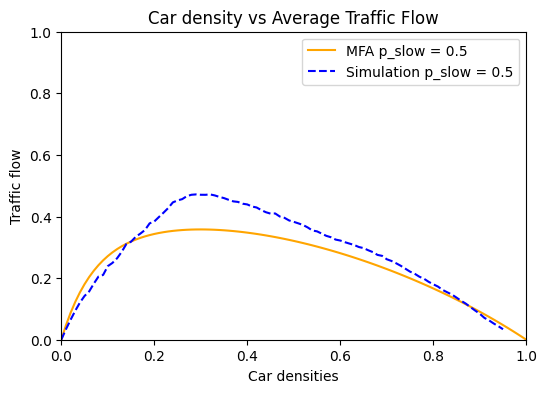

In [276]:
plt.figure(figsize=(6, 4))
plt.title("Car density vs Average Traffic Flow")
plt.xlabel('Car densities')
plt.ylabel('Traffic flow')
plt.xlim(0, 1)
plt.ylim(0, 1)

colors = ['orange', 'blue', 'green']

plt.plot(car_densities2, mfa_flow_results[0], '-', label=f'MFA p_slow = {p}', color = colors[0])

plt.plot(car_densities, traffic_flow[0], '--', label=f'Simulation p_slow = {p}', color = colors[1], )

plt.legend()
plt.show()



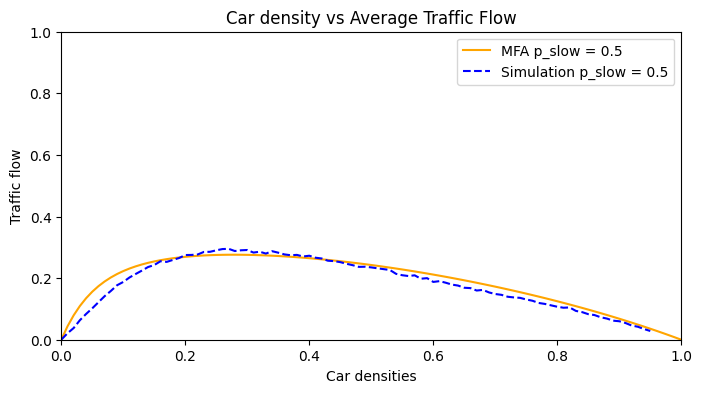

In [272]:
plt.figure(figsize=(8, 4))
plt.title("Car density vs Average Traffic Flow")
plt.xlabel('Car densities')
plt.ylabel('Traffic flow')
plt.xlim(0, 1)
plt.ylim(0, 1)

colors = ['orange', 'blue', 'green']

plt.plot(car_densities2, mfa_flow_results[0.25], '-', label=f'MFA p_slow = {p}', color = colors[0])

plt.plot(car_densities, traffic_flow[0.25], '--', label=f'Simulation p_slow = {p}', color = colors[1], )

plt.legend()
plt.show()

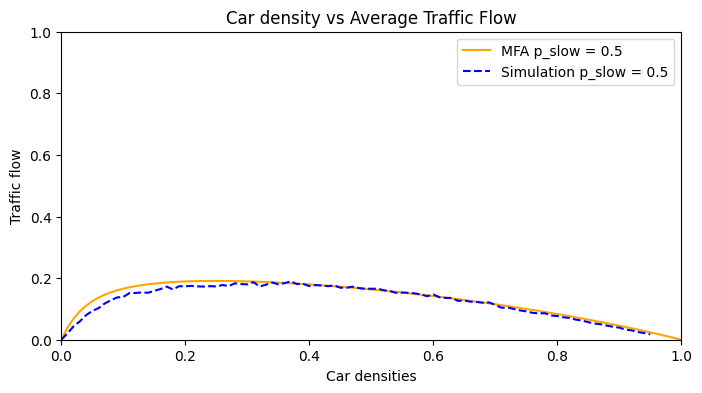

In [273]:
plt.figure(figsize=(8, 4))
plt.title("Car density vs Average Traffic Flow")
plt.xlabel('Car densities')
plt.ylabel('Traffic flow')
plt.xlim(0, 1)
plt.ylim(0, 1)

colors = ['orange', 'blue', 'green']

plt.plot(car_densities2, mfa_flow_results[0.5], '-', label=f'MFA p_slow = {0.5}', color = colors[0])

plt.plot(car_densities, traffic_flow[0.5], '--', label=f'Simulation p_slow = {0.5}', color = colors[1], )

plt.legend()
plt.show()